#\ - comments that should be delected at some point and should be looked into if they still remain in the code, possible represent future endeavors
#comment - former or temp lines of code that are currently commented, either need to be deleted or uncommented to be used again at some point
- #_comment - # comment - represents an actual comment that should stay in the code after finished, describes the code in some way or provides clarity


In [848]:
#import statements
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize
from pymoo.constraints.as_penalty import ConstraintsAsPenalty
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from matplotlib.markers import MarkerStyle

,0,1,2,3,4
0,inf,140.771726,86.141689,132.218716,180.377579
1,140.771726,inf,80.660747,25.862853,39.614337
2,86.141689,80.660747,inf,60.298902,116.087346
3,132.218716,25.862853,60.298902,inf,55.919286
4,180.377579,39.614337,116.087346,55.919286,inf


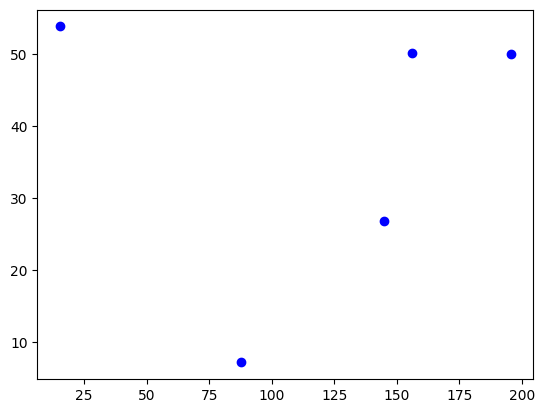

In [849]:
# Edited version of Henry's code for importing a graph
rnd = np.random
rnd.seed(7)
n = 5 # clients
xc = rnd.rand(n)*200
yc = rnd.rand(n)*100
plt.scatter(xc,yc,c='b')
# set of clients


N = [i for i in range(1,n)]
V = [0] + N
# connecting every point to every point
A = [(i,j) for i in V for j in V if i!=j]
# Generating distances from each point
c = {(i,j): np.hypot(xc[i]-xc[j],yc[i]-yc[j]) for i,j in A}
c[(0,0)] = np.inf
c[(1,1)] = np.inf
c[(2,2)] = np.inf
c[(3,3)] = np.inf
c[(4,4)] = np.inf

distances = [[c.get((i,j), 0) for j in range(5)] for i in range(5)]

dist_matrix = pd.DataFrame(distances, columns=V, index=V)

dist_matrix


# Graph function

In [850]:
# This class controls all the information for how to set up and display the graph, 
#   so it displays the graph information and the pymoo optimizations
class Graph: 
    # Code for showing the initial graph
    # numN = number of nodes
    # uppB = upperbounds of x
    # lowB = lowerbounds of x
    # precision = the decimal place the numbers will be to (ex: precision = 1 means that it will be to the tenths or .1 precision)
    # seed = the random seed to ensure the results are repeatable
    # costA = array of all the nodes cost (distance) to one another
    # xc = x coordinates of locations
    # yc = y coordinate of locations
    def __init__(self, numN, uppB, lowB, precision, seedNum):
        self.numN = numN
        self.uppB = uppB
        self.lowB = lowB
        self.precision = precision
        self.seedNum = seedNum
        self.nodes = None
        self.costA = None
        self.xc = None
        self.yc = None
        self.genNodes()
        
    
    # displays the graph with the supplied informaion
    # showEdges - boolean value used to determine if the graph with show connections or not
    def showGraph(self, showEdges):
        print(self.nodes) #remove this line at some point

        rnd = np.random
        rnd.seed(self.seedNum)
        xc = rnd.rand(self.numN)*200
        yc = rnd.rand(self.numN)*100

        plt.scatter(xc,
                    yc, 
                    s = 150,
                    marker = MarkerStyle("o"), 
                    facecolors='white', 
                    edgecolors='blue',
                    zorder = 1 )
        
        # Displays the ids of each node
        for i in self.nodes:
            plt.text(xc[i], yc[i], i+1, horizontalalignment='center', verticalalignment='center')

        # If True, then the graph shows its connections and the cost
        if (showEdges == True):
            #print('hahahahahahahahahaahaha not done yet')
            for i in range(self.numN-1):
                plt.plot([xc[i], xc[i+1]], [yc[i], yc[i+1]], color = 'black', zorder = 0)
                print(i)



    # displays the 2d arrays howing the costs between all the nodes
    def showCost(self):
        print(self.costA)
        
    # generates the random nodes, and calculates the cost (distance) 
    #   between every node in the graph and stores it in a 2D array
    #   and then stores this information in nodes and costA respectively
    # returns a np.array of the costs to each node
    def genNodes(self):
        
        rnd = np.random
        rnd.seed(self.seedNum)
        xc = rnd.rand(self.numN)*200
        yc = rnd.rand(self.numN)*100
        self.xc = xc
        self.yc = yc
        #plt.scatter(xc,yc,c='b')
        # set of clients


        N = [i for i in range(1,self.numN)]
        V = [0] + N
        self.nodes = np.array(V)
        # connecting every point to every point
        A = [(i,j) for i in V for j in V if i!=j]
        costArr = np.zeros((self.numN,self.numN))
        # Generates cost between vertices
        for i,j in A :
            costArr[i][j] = np.hypot(xc[i]-xc[j],yc[i]-yc[j])
            if (i==j):
                costArr[i][j] = 0
            costArr[i][j] = costArr[i][j].round(self.precision)

        self.costA = costArr

        



## This Block is to test the graph function without any pymoo input

[0 1 2 3 4]
[[  0.  140.8  86.1 132.2 180.4]
 [140.8   0.   80.7  25.9  39.6]
 [ 86.1  80.7   0.   60.3 116.1]
 [132.2  25.9  60.3   0.   55.9]
 [180.4  39.6 116.1  55.9   0. ]]
[0 1 2 3 4]
0
1
2
3


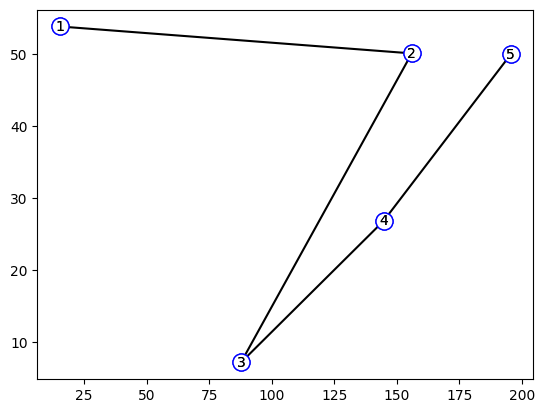

In [851]:
nNodes = 5
uppB = 1
lowB = 0
precision = 1
seedNum = 7
gTest = Graph(nNodes, uppB, lowB, precision, seedNum)
#gTest.showCost
gTest.showGraph(False)
gTest.showCost()
gTest.showGraph(True)

In [852]:
#element wise problem looks at one solution at a time, normal problem would look at all problems at once
class longestPath(ElementwiseProblem):
    def __init__(self, dist_matrix): # initilization/constructor function

        self.dist_matrix=dist_matrix

        # defines that diagnals (duplicates) can't be used in the algorithm
        #Ask Dr. Kropp why the population isn't this - he's not sure, go back when he's available
        #upper = np.array([[0,1,1,1,1], [0,0,1,1,1], [0,0,0,1,1], [0,0,0,0,1], [0,0,0,0,0]])
        #print (upper)        
        #upper=upper.reshape((25))
        #print(upper)
        #lower = np.array([[0,1,1,1,1], [0,0,1,1,1], [0,0,0,1,1], [0,0,0,0,1], [0,0,0,0,0]])
        #lower=lower.reshape((25))
        # n_var = number of connections, n_obj=?, n_ieq_constr=?, x1 = 1 (lowest node besides 0 as 0 can't conenct to itself), xu = highest node id (# nodes minus 1)
        super().__init__(n_var=n-1, n_obj=1, n_ieq_constr=0, xl=1, xu=n-1)
        

    #x is a random solution or population to the problem, that is automatically created
    def _evaluate(self, x, out, *args, **kwargs): 
        
        # reshaping x to be a matrix of 5 by 5
        #x = x.reshape ((5,5))
        print("funny")
        print(x)
        
        # fills in the array with all the connection distances (when there is a connection (c=1), assign the length to the dist_matrix, otherwise mark the distance as 0 to show theres no connection)
        dist_mask = np.array(np.where(x==1, self.dist_matrix, 0))
        
        
        
        
        out["F"] = -np.sum(dist_mask)
        # out["G"] = 0.1 - out["F"]


In [853]:
problem = longestPath(dist_matrix)

# take the best 1 out of the 2 generated solutions (pop_size) and use them to breed the next generation, this will happen for 10 (n_gen) generations
algorithm = GA(
    pop_size= 2,
    # can only be 1 or 0
    sampling=IntegerRandomSampling(),
    # how the solutions are passed onto each generations
    crossover=SBX(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    mutation=PM(prob=1.0, eta=3.0, vtype=float, repair=RoundingRepair()),
    eliminate_duplicates=True)

res = minimize(problem,
            algorithm,
            termination=('n_gen', 10),
            seed=1,
            save_history=False)

funny
[2 1 4 4]


ValueError: operands could not be broadcast together with shapes (4,) (5,5) () 

In [ ]:
print(res.X.reshape((5,5)))
res.F

rnd = np.random
# Ensure that the randomly generated points can be reused
rnd.seed(7)
# sets the number of points to 5
n = 5
# generate points x values
xc = rnd.rand(n)*200
# generate points y values
yc = rnd.rand(n)*100
# plot points
plt.scatter(xc[:],yc[:],c='b')
matrixX = res.X.reshape((5,5))
for i in range(matrixX.shape[0]):
    for j in range(matrixX.shape[1]):
        if matrixX[i, j] == 1:
            plt.plot([xc[i], xc[j]], [yc[i], yc[j]], 'k-')
